<a href="https://colab.research.google.com/github/avyaktawrat/Evaluat-inator/blob/master/Content_Based_%7C_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Content Based Recommendation
Movies are recommended based on their genres alone

**All the EDA has been saved in another colab file**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# 1M MovieLens dataset has been used
movies = pd.read_csv('https://github.com/avyaktawrat/Evaluat-inator/raw/master/data/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
users = pd.read_csv('https://github.com/avyaktawrat/Evaluat-inator/raw/master/data/users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv('https://github.com/avyaktawrat/Evaluat-inator/blob/master/data/ratings.dat?raw=true', sep = '::', header = None, engine = 'python', encoding = 'latin-1')

movies.columns = ['movieId', 'title', 'genres']
users.columns = ['userId',	'gender',	'age_desc',	'occ_desc', 'zipcode']
ratings.columns = ['userId',	'movieId',	'rating',	'timestamp']

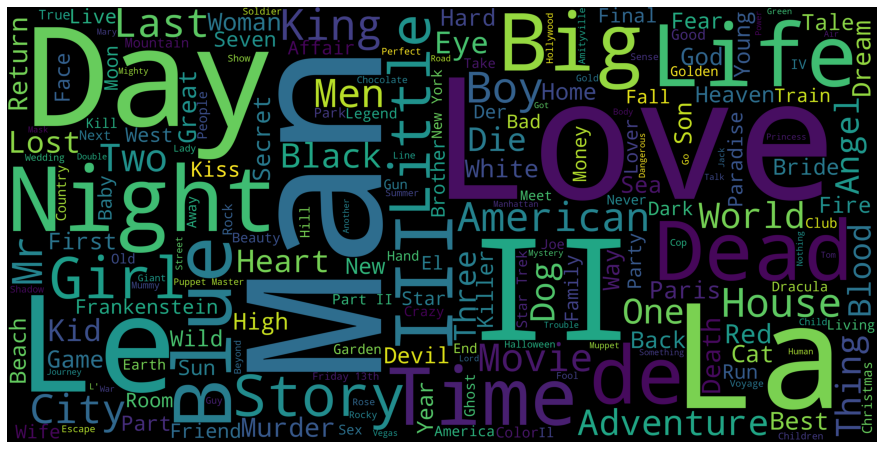

In [40]:
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [0]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 127)

In [43]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix[:20000], tfidf_matrix[:20000])
cosine_sim[:4, :4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

In [0]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [45]:
genre_recommendations('Toy Story (1995)')

1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
236                                 Goofy Movie, A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          

In [46]:
movies.iloc[(movies.title=='Toy Story (1995)').values]

,movieId,title,genres
0,1,Toy Story (1995),"['Animation', ""Children's"", 'Comedy']"


#Collaborative Filtering Recommendation Model

In [47]:
dataset = pd.merge(pd.merge(movies, ratings),users)
dataset.head()

,movieId,title,genres,userId,rating,timestamp,gender,age_desc,occ_desc,zipcode
0,1,Toy Story (1995),"['Animation', ""Children's"", 'Comedy']",1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),"['Animation', ""Children's"", 'Musical', 'Romance']",1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),['Drama'],1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),"['Drama', 'War']",1,5,978824195,F,1,10,48067


In [48]:
dataset.shape

(1000209, 10)

In [49]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [0]:
ratings = ratings.dropna()

In [0]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ratings, test_size=0.2)

In [0]:
## Ratings are on scale of 1-5, unrated moveis are rated 0 initially
index = ratings.userId.unique()
index.sort()

columns = ratings.movieId.astype(np.int64).unique()
columns.sort()

data_matrix = pd.DataFrame(np.zeros((index.shape[0], columns.shape[0])), index, columns)
for i in train_data.itertuples():
    data_matrix.loc[i[1], i[2]] = i[3]

# using the entire matrix for evaluation
test_matrix = data_matrix
for i in test_data.itertuples():
    test_matrix.loc[i[1], i[2]] = i[3]

train_data = data_matrix
test_data = test_matrix

In [53]:
# dataframe having userId as index and movieId as columns
data_matrix.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


pairwise_distances function from sklearn to calculate the Pearson Correlation Coefficient
https://datascience.stackexchange.com/questions/49198/what-does-sklearns-pairwise-distances-with-metric-correlation-do

In [0]:
 from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0

In [55]:
user_correlation[:4,:4]

array([[1.        , 0.07689583, 0.10863359, 0.12504067],
       [0.07689583, 1.        , 0.1340226 , 0.16108024],
       [0.10863359, 0.1340226 , 1.        , 0.14423706],
       [0.12504067, 0.16108024, 0.14423706, 1.        ]])

In [56]:
item_correlation[:4,:4]

array([[1.        , 0.26264945, 0.14653623, 0.10937542],
       [0.26264945, 1.        , 0.16958627, 0.111616  ],
       [0.14653623, 0.16958627, 1.        , 0.1586589 ],
       [0.10937542, 0.111616  , 0.1586589 , 1.        ]])

In [57]:
train_data.mean(axis=1)[:,np.newaxis]

array([[0.05990286],
       [0.12924987],
       [0.05369671],
       ...,
       [0.02050729],
       [0.1287102 ],
       [0.3291959 ]])

In [0]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred = pred.to_numpy()
    return pred

# Evaluation

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [0]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data, user_correlation, type='user')
item_prediction = predict(train_data, item_correlation, type='item')

In [61]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data.to_numpy())))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data.to_numpy())))

User-based CF RMSE: 2.896405015098818
Item-based CF RMSE: 3.160155629440562


In [0]:
# Predict ratings on the test data with both similarity score
user_prediction = predict(test_data, user_correlation, type='user')
item_prediction = predict(test_data, item_correlation, type='item') 

In [63]:
# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data.to_numpy())))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data.to_numpy())))

User-based CF RMSE: 2.896405015098818
Item-based CF RMSE: 3.160155629440562
